In [1]:
import os
import os.path
import pickle

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
help(XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(*, objective='binary:logistic', use_label_encoder=True, **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : int
 |          Number of boosting rounds.
 |      use_label_encoder : bool
 |          (Deprecated) Use the label encoder from scikit-learn to encode the labels. For new code,
 |          we recommend that you set this parameter to False.
 |  
 |      max_depth : int
 |          Maximum tree depth for base learners.
 |      learning_rate : float
 |          Boosting learning rate (xgb's "eta")
 |      verbosity : int
 |          The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
 |      objective : string or callable
 |          Specify the learning task and the corresponding learning objective or
 |          a custom objective func

In [3]:
NOTE = '全特徴量を使用したXGBoost.カテゴリ変数はダミーエンコーディングしている。'

N = 5
CV = f'Stratified-Kfold(K={N})'

notebook_name = '016_XGB'
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1
CATEGORICAL_FEATURES =  [
        'batterID', 'pitcherID', 'Match',
        'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher',
        'isBottom', 'batterTeam', 'pitcherTeam'
    ]

016_submission.csv 016_XGB


In [4]:
def get_estimator(categorical_features, discrete_features):
    discrete_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('discrete', discrete_transformer, discrete_features),
            ('categorical', 'passthrough', categorical_features),
        ]
    )
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('estimator', XGBClassifier(n_estimators=200,
                                        n_jobs=-1,
                                        random_state=SEED
                                       )
            )
        ]
    )

In [5]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [6]:
for c in CATEGORICAL_FEATURES:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])

train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)

assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

In [7]:
categorical_features = []
for c in CATEGORICAL_FEATURES:
    categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features

['batterID_0',
 'batterID_2',
 'batterID_5',
 'batterID_9',
 'batterID_11',
 'batterID_12',
 'batterID_15',
 'batterID_18',
 'batterID_19',
 'batterID_21',
 'batterID_22',
 'batterID_26',
 'batterID_27',
 'batterID_28',
 'batterID_29',
 'batterID_31',
 'batterID_34',
 'batterID_36',
 'batterID_37',
 'batterID_39',
 'batterID_42',
 'batterID_45',
 'batterID_47',
 'batterID_50',
 'batterID_55',
 'batterID_56',
 'batterID_58',
 'batterID_60',
 'batterID_67',
 'batterID_70',
 'batterID_72',
 'batterID_73',
 'batterID_75',
 'batterID_80',
 'batterID_82',
 'batterID_84',
 'batterID_85',
 'batterID_87',
 'batterID_89',
 'batterID_91',
 'batterID_98',
 'batterID_102',
 'batterID_103',
 'batterID_105',
 'batterID_106',
 'batterID_111',
 'batterID_112',
 'batterID_114',
 'batterID_117',
 'batterID_118',
 'batterID_120',
 'batterID_121',
 'batterID_125',
 'batterID_127',
 'batterID_128',
 'batterID_130',
 'batterID_132',
 'batterID_134',
 'batterID_135',
 'batterID_137',
 'batterID_138',
 'batter

In [8]:
features = [c for c in train.columns if c not in ('id', 'y')]
assert(set(features) - set(test.columns.tolist()) == set())

In [9]:
discrete_features = [f for f in features if f not in categorical_features]
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'b1',
 'b2',
 'b3',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabe

In [10]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator(categorical_features, discrete_features)
    clf.fit(X_train, y_train)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:12:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 1)**********
[[5059    3    4    0    0    0    0    0]
 [  23 3700   23    0    0    0    0    0]
 [  57   23 2313    0    0    0    0    0]
 [   0    0    0 1709    0    0    0    0]
 [   0    0    0    0  540    0    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[695 294 209  43  19   2   1   4]
 [391 329 158  41   8   6   0   3]
 [236 156 152  39   8   4   0   4]
 [ 94  61  69 200   3   0   0   0]
 [ 35  18  22  54   6   0   0   0]
 [  7   7   2  20   1   0   0   0]
 [  0   0   1   2   0   0   0   0]
 [  4   2   8  10   0   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 2)**********
[[5056    4    6    0    0    0    0    0]
 [  11 3710   25    0    0    0    0    0]
 [  64   35 2294    0    0    0    0    0]
 [   0    0    0 1709    0    0    0    0]
 [   0    0    0    0  540    0    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 2)**********
[[671 312 215  40  18   8   0   3]
 [369 343 168  37  10   4   1   4]
 [236 165 138  42  10   3   0   5]
 [ 85  53  70 212   7   0   0   0]
 [ 32  19  27  56   1   0   0   0]
 [  5   6   8  16   2   0   0   0]
 [  0   1   0   1   0   0   0   0]
 [  3   6   3   9   3   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 3)**********
[[5053    4    9    0    0    0    0    0]
 [  15 3706   25    0    0    0    0    0]
 [  83   38 2273    0    0    0    0    0]
 [   0    0    0 1708    0    0    0    0]
 [   0    0    0    0  540    0    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 3)**********
[[687 335 183  35  13   8   2   4]
 [408 331 152  30   8   3   0   4]
 [230 136 168  45   9   7   1   2]
 [ 81  42  83 219   3   0   0   0]
 [ 21  20  18  74   2   0   0   0]
 [  8   7   5  15   2   0   0   0]
 [  0   1   0   1   0   0   0   0]
 [  3   4   2  14   1   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 4)**********
[[5050    5   12    0    0    0    0    0]
 [  14 3717   14    0    0    0    0    0]
 [  86   22 2286    0    0    0    0    0]
 [   0    0    0 1709    0    0    0    0]
 [   0    0    0    0  540    0    0    0]
 [   0    0    0    0    0  149    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 4)**********
[[677 316 216  32  11  10   0   4]
 [379 362 142  36  10   2   3   3]
 [225 162 150  37  19   4   0   1]
 [ 83  52  85 203   3   0   0   1]
 [ 35  20  24  51   5   0   0   0]
 [  6   8   6  16   2   0   0   0]
 [  2   0   0   0   0   0   0   0]
 [  4   4   2  14   0   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 5)**********
[[5055    3    9    0    0    0    0    0]
 [  15 3720   10    0    0    0    0    0]
 [  82   24 2288    0    0    0    0    0]
 [   0    0    0 1709    0    0    0    0]
 [   0    0    0    0  540    0    0    0]
 [   0    0    0    0    0  149    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 5)**********
[[665 334 199  38  16  11   0   3]
 [382 347 154  40   6   7   0   1]
 [231 149 146  49  19   1   0   3]
 [ 92  51  84 192   7   0   0   1]
 [ 30  14  23  67   1   0   0   0]
 [  9   7   2  20   0   0   0   0]
 [  0   0   1   1   0   0   0   0]
 [  7   3   4   9   1   0   0  

In [11]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.994177,0.205985
std,0.000648,0.005996
min,0.993153,0.197514
25%,0.994091,0.201987
50%,0.994263,0.208576
75%,0.994475,0.210380
max,0.994904,0.211466


In [12]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,1,0,1
2,2,0,0,0,1
3,3,2,2,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,2,0,5
17129,9693,1,2,0,5
17130,16833,1,1,0,5
17133,9762,1,2,0,5


In [13]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.076186,0.453776,0.470018,3.785068e-08,1.194855e-06,2.705670e-06,7.065385e-06,9.474277e-06,27446,1
1,0.575598,0.224493,0.199906,1.476962e-09,5.279975e-08,2.104990e-07,1.505687e-06,1.124130e-06,113,1
2,0.532037,0.361784,0.106178,2.284443e-11,2.279495e-10,2.331766e-08,7.017100e-07,1.433152e-07,4479,1
3,0.563050,0.329995,0.106954,2.417604e-11,2.412368e-10,2.467686e-08,7.426131e-07,1.516692e-07,29080,1
4,0.794674,0.111749,0.093575,1.030588e-10,1.855755e-09,5.724249e-08,7.620178e-07,6.574727e-07,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.134443,0.730844,0.134691,1.292963e-05,4.577258e-06,4.417057e-06,5.039454e-07,2.544752e-07,24272,5
33804,0.234970,0.308133,0.359749,6.626356e-02,2.995635e-02,9.030626e-04,6.778614e-06,1.738127e-05,29106,5
33805,0.165061,0.211837,0.157666,4.216726e-01,4.304226e-02,7.008847e-04,4.511803e-06,1.518610e-05,20679,5
33806,0.902376,0.028332,0.069058,6.542045e-05,1.604795e-04,6.744271e-06,5.973944e-07,3.460492e-07,25901,5


In [14]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.641124,3.023180,1.335689,5.137370e-10,7.241901e-08,1.522102e-06,0.000005,7.135396e-07
1,1,2.725605,1.748640,0.525752,4.354113e-10,3.963006e-09,2.045558e-07,0.000003,3.006059e-07
2,2,0.170557,1.869741,2.540663,3.939836e-01,2.608460e-03,3.679127e-03,0.000113,1.865461e-02
3,3,2.284215,2.296290,0.419482,3.753498e-06,1.771213e-06,2.698736e-06,0.000003,6.018265e-07
4,4,2.034676,2.414949,0.550369,2.837834e-09,6.148232e-07,2.930023e-07,0.000004,1.016536e-06
...,...,...,...,...,...,...,...,...,...
33803,33803,3.808429,0.582911,0.608653,7.305679e-11,4.390632e-09,6.535802e-07,0.000004,1.972390e-06
33804,33804,2.356546,2.156152,0.487289,4.248086e-06,1.292457e-06,2.160178e-06,0.000003,2.063298e-06
33805,33805,3.138456,1.415620,0.445904,2.760931e-06,1.273567e-06,1.972509e-06,0.000009,4.914290e-06
33806,33806,0.146706,0.974701,3.877611,1.798731e-04,2.491425e-04,5.001464e-04,0.000024,2.811278e-05


In [15]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,0
2,2,2
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,0
33805,33805,0
33806,33806,2


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.502840
1    0.325515
2    0.159164
3    0.012482
Name: y, dtype: float64

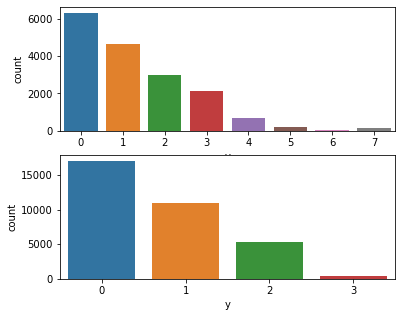

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [17]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [18]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.9941772474168176, 0.20598451129476572)

In [19]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"016_submission.csv","Stratified-Kfold(K=5)","0.994177","0.205985","","全特徴量を使用したXGBoost.カテゴリ変数はダミーエンコーディングしている。"


In [20]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 1.15 s
